## Soft Actor-Critic: SAC with 1 Net in Pendulum

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.16774695, -0.98583007,  0.25403628], dtype=float32)

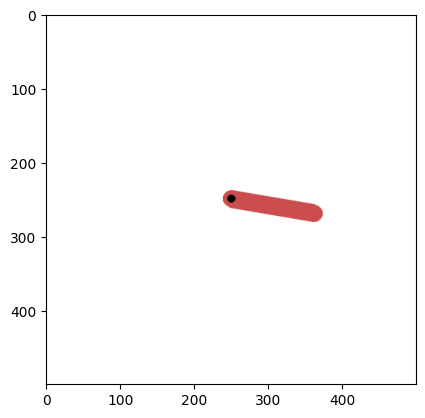

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [3]:
import torch

# 定义模型
class ModelAction(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc_state = torch.nn.Sequential(
			torch.nn.Linear(3, 128),
			torch.nn.ReLU(),
		)
    
    self.fc_mu = torch.nn.Linear(128, 1)
    self.fc_std = torch.nn.Sequential(
			torch.nn.Linear(128, 1),
			torch.nn.Softplus(),
		)
    
  def forward(self, state):
    # [b, 3] -> [b, 128]
    state = self.fc_state(state)
    
    # [b, 128] -> [b, 1]
    mu = self.fc_mu(state)
    
    # [b, 128] -> [b, 1]
    std = self.fc_std(state)
    
    # 根据mu, std定义b个正态分布
    dist = torch.distributions.Normal(mu, std)
    
    # 采样b个样本
    # 这里用的是rsample,表示重采样,
    # 其实就是先从一个标准正态分布中采样,然后乘以标准差,加上均值
    sample = dist.rsample()
    
    # 样本压缩到-1,1之间，求动作
    action = torch.tanh(sample)
    
    # 求概率对数
    log_prob = dist.log_prob(sample)
    
    # 这个值描述动作的熵
    entropy = log_prob - (1 - action.tanh() ** 2 + 1e-7).log()
    entropy = - entropy
    
    return action * 2, entropy

model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[-0.1350],
         [-1.8410]], grad_fn=<MulBackward0>),
 tensor([[1.1032],
         [3.8129]], grad_fn=<NegBackward0>))

In [4]:
class ModelValue(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential = torch.nn.Sequential(
			torch.nn.Linear(4, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1),
		)
    
  def forward(self, state, action):
    # [b, 3 + 1] -> [b, 4]
    state = torch.cat([state, action], dim=1)
    
    # [b, 4] -> [b, 1]
    return self.sequential(state)


model_value = ModelValue()
model_value_next = ModelValue()
model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(2, 3), torch.randn(2, 1))

tensor([[-0.1160],
        [-0.0749]], grad_fn=<AddmmBackward0>)

In [5]:
import random
import numpy as np 

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 3)
  action, _ = model_action(state)
  return action.item()

get_action([1, 2, 3])

-1.4442546367645264

In [6]:
# 样本池
datas = []

def update_data():
  state = env.reset()
  
  # 玩到结束
  over = False
  while not over:
    action = get_action(state)
    
    next_state, reward, over, _ = env.step([action])
    
    datas.append((state, action, reward, next_state, over))
    
    state = next_state
    
  while len(datas) > 10000:
    datas.pop(0)
    
update_data()

len(datas), datas[0]

(200,
 (array([ 0.9659122 ,  0.25886992, -0.3923112 ], dtype=float32),
  0.5372892022132874,
  -0.08424598187650034,
  array([ 0.9674172 ,  0.25318757, -0.11756539], dtype=float32),
  False))

In [7]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
  # [b, 1]
  action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_17032\2582340429.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[-0.9926, -0.1216,  8.0000],
         [-0.8669, -0.4985,  8.0000],
         [ 0.4022,  0.9156,  7.0662],
         [ 0.8826,  0.4702,  6.1493],
         [ 0.3733, -0.9277,  6.7710]]),
 tensor([[1.9961],
         [1.9241],
         [1.9973],
         [1.9843],
         [1.9791]]),
 tensor([[-15.5224],
         [-13.2664],
         [ -6.3355],
         [ -4.0249],
         [ -6.0003]]),
 tensor([[-0.8669, -0.4985,  8.0000],
         [-0.6077, -0.7942,  7.9147],
         [ 0.0139,  0.9999,  8.0000],
         [ 0.6753,  0.7376,  6.7995],
         [ 0.6451, -0.7641,  6.3721]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step([action])
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

-1474.5824845183108

In [9]:
def soft_update(model, model_next):
  for param, param_next in zip(model.parameters(), model_next.parameters()):
    # 小比例更新
    value = param_next.data * 0.995 + param.data * 0.005
    param_next.data.copy_(value)
    
soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [10]:
# alpha 

In [11]:
def get_target(reward, next_state, over):
  # 首先使用model_action计算动作和动作的熵
  # [b, 3] -> [b, 1], [b, 1]
  action, entropy = model_action(next_state)
  
  # 评估next_state的价值
  # [b, 4], [b, 1] -> [b, 1]
  target = model_value_next(next_state, action)
  
  
  # 还原alpha,
  target += 0.005 * entropy
  
  # [b, 1] 
  target *= 0.99
  target *= (1 - over)
  target += reward
  
  return target

get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [12]:
def get_loss_action(state):
	# 计算action和熵
	# [b, 3] -> [b, 1], [b, 1]
	action, entropy = model_action(state)

	# 使用两个value网络评估action的价值
	#[b, 3],[b, 1] -> [b, 1]
	value = model_value(state, action)

	# 熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
	# [1] - [b, 1] -> [b, 1]
	loss_action = -0.005 * entropy
  
	# 减去value,所以value越大越好,这样loss就会越小
	loss_action -= value

	return loss_action.mean()

get_loss_action(state)

tensor(-0.2910, grad_fn=<MeanBackward0>)

In [13]:
def train():
  optimizer_action = torch.optim.Adam(model_action.parameters(), lr=3e-4)
  optimizer_value = torch.optim.Adam(model_value.parameters(), lr=3e-3)
  
  loss_fn = torch.nn.MSELoss()
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(200):
    # 更新N条数据
    update_data()
    
    # 每次更新过后，学习N次
    for i in range(200):
      # 采样一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 对reward 偏移，便于训练
      reward = (reward + 8) / 8 
      
      # 计算value和target, target已经考虑了动作和熵
      # [b, 1]
      target = get_target(reward, next_state, over)
      target = target.detach()
      
      # 计算1个value
      value = model_value(state, action)
      
      # 计算1个loss,value的目标都是要贴近target
      loss_value = loss_fn(value, target)
      
      # 更新参数
      optimizer_value.zero_grad()
      loss_value.backward()
      optimizer_value.step()
      
      # 使用model_value计算model_action的loss, 更新参数
      loss_action = get_loss_action(state)
      optimizer_action.zero_grad()
      loss_action.backward()
      optimizer_action.step()
      
      # 小比例更新
      soft_update(model_value, model_value_next)
      
    if epoch % 20 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, len(datas), test_result)
      
train()

0 400 -1301.0504323525515
20 4400 -785.7459317748038
40 8400 -207.50821797930047
60 10000 -473.11297732464766
80 10000 -145.54039523189257
100 10000 -162.23843811218413
120 10000 -192.92690805043628
140 10000 -140.31122568767037
160 10000 -229.13106844934882
180 10000 -127.72825020520841


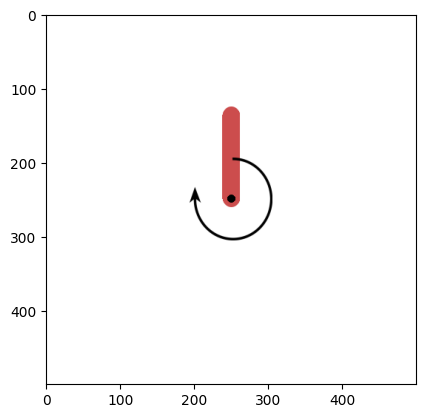

-116.23862153175149

In [14]:
test(play=True)